In [1]:
import pyart
from fix_velocity import driver_fix_velocity

radar = pyart.io.read_cfradial('/Users/lo-y/vcor_dual_prf/vcor_dual_prf/radar/FRCIS/SYAKA/SYAKA_20240829_051000_V13.nc')
velocity_corrected = driver_fix_velocity(radar, band='C', piecewise_corr=False, spectrum_width_filter=False)

radar.add_field_like('V', 'VEL', velocity_corrected)
#radar.add_field_like('V', 'MAE', mae)



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



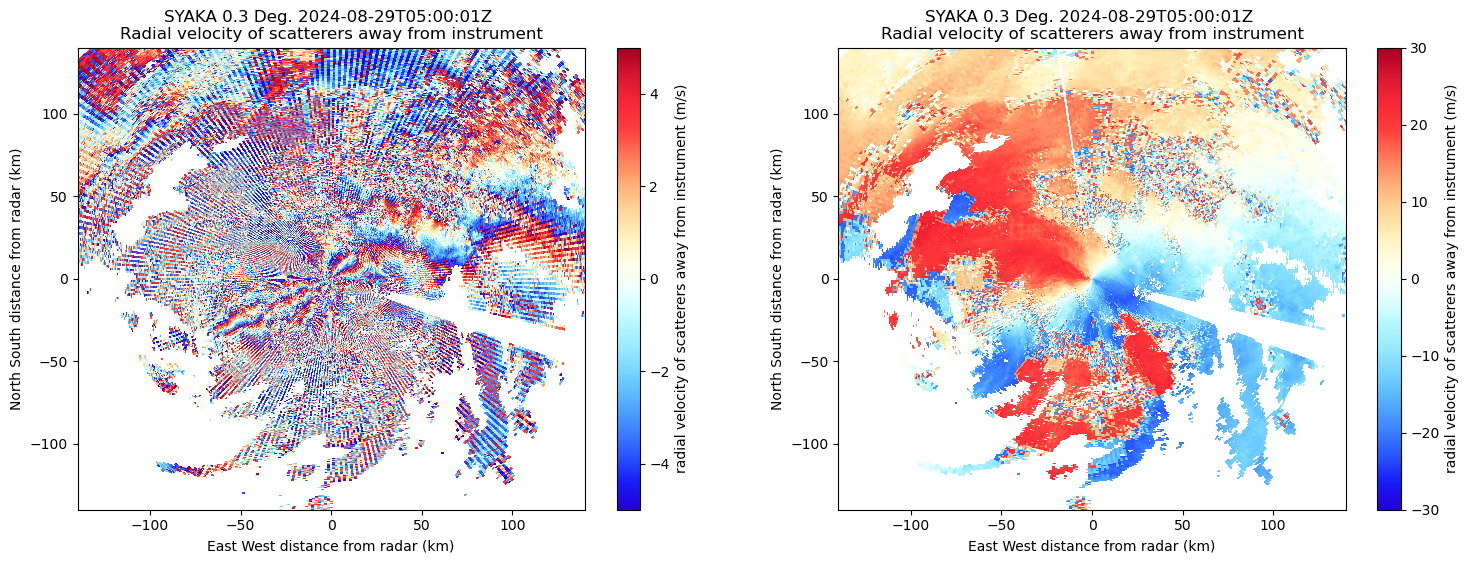

In [2]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

sweep = 0
display = pyart.graph.RadarDisplay(radar)
display.set_limits((-70, 70), (-70, 70), ax=ax1)
display.plot_ppi('V', sweep, cmap="BuDRd18", vmin=-5, vmax=5, ax=ax1)

display.set_limits((-70, 70), (-70, 70), ax=ax2)
#display.plot_ppi('MAE', sweep, cmap="BuDRd18", vmin=0, vmax=5, ax=ax2)
display.plot_ppi('VEL', sweep, cmap="BuDRd18", vmin=-30, vmax=30, ax=ax2)

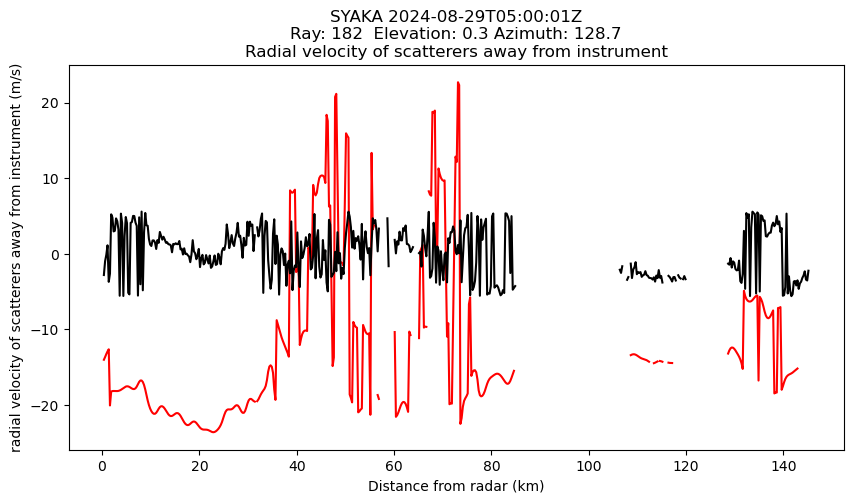

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

ray = 182
display.plot_ray('VEL', ray, ax=ax, format_str='r-')
display.plot_ray('V', ray, ax=ax)
#display.plot_ray('MAE', ray, ax=ax, format_str='g-')